# Milestone Project 2: Skimlit 🧾🔥

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be uisng) is available here: https://arxiv.org/pdf/1710.06071.pdf

And reading through the paper above, we see that the model architecture that they use to achieve their best results is avaliable here: https://arxiv.org/pdf/1612.05251.pdf

In [1]:
# Imports
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

print(tf.__version__)

2.12.0


## Confirm access to a GPU

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-51f71da6-ce2e-e129-50e1-a340da51d725)


## Get the data

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset ther used.

We can download from the authours GitHub acount: https://github.com/Franck-Dernoncourt/pubmed-rct

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (33/33), 177.08 MiB | 44.96 MiB/s, done.
Resolving deltas: 100% (12/12), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [5]:
# Start our experiments using the 20K dataset with numbers replaced by '@' sign
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [6]:
# Check all of the file name in the target directory
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess data

We have got some data, now it is time to explore the data. (Become one with it)

The best way to becoming one with data is visualize, visualize and visualize..

Let's write a function to read in all of the lines of a target text file.

In [7]:
# Create a function to read the lines in the documents
def get_lines(filename):
  '''
  Reads a text filename and return the all line as a list format

  Args:
    filename: a string containing the target filepath

  Return:
    A list of string with one string per line from the target filename.
  '''

  with open(filename) as f:
    return f.readlines()

In [8]:
# Check the train path
filenames[0]

'/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt'

In [9]:
# Let's read in the training lines
train_lines = get_lines(filenames[0])
train_lines[:44]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [10]:
# Check the length of training lines
len(train_lines)

210040

Let's think about what kind of data representation is the best for our model..

Get a single example from above: `'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n'`

Format I want for the model:
    <br>[{'line_number': 3,
    <br>'target': 'METHODS',
    <br>'text': 'Outcome measures included pain reduction and improvement <br>in function scores and systemic inflammation markers .'
    <br>'total_lines': 12 }]


<br> Let's write a function for this format...

In [11]:
def preprocess_text_with_line_numbers(filename):
  '''
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentence, how many
  sentences are in the current abstract and what sentence number the target
  line is.
  '''
  input_lines = get_lines(filename) # get all lines from filename
  sublists = [] # Define an emptysublist
  current_sublist = [] # Define an empty current sublist
  # Divide the input lines and create sublists between '###ID' and '\n'
  for line in input_lines:
    if line.startswith('###'):
      pass
    elif line.isspace():
      sublists.append(current_sublist)
      current_sublist = []
    else:
      current_sublist.append(line)
  # Create an empty list for adding all dict
  dict_list = []
  # Loop through the sublist
  for sub_list in sublists:
    # Another loop for the each line
    for index, per_line in enumerate(sub_list):
      splited_per_line = per_line.strip().split('\t')
      # Create a dict and add all key and values
      per_line_dict = {
          'line_number': index,
          'target': splited_per_line[0],
          'text': splited_per_line[1].lower(),
          'total_lines': len(sub_list) - 1
      }
      # Add the per line dictionary into dictionary list
      dict_list.append(per_line_dict)

  return dict_list

In [12]:
# Get the data from file
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + 'train.txt')
val_samples = preprocess_text_with_line_numbers(data_dir + 'dev.txt') # dev is another name of validation
test_samples = preprocess_text_with_line_numbers(data_dir + 'test.txt')
print('Total number of train samples:', len(train_samples))
print('Total number of validation samples:', len(val_samples))
print('Total number of test samples:', len(test_samples))

Total number of train samples: 180040
Total number of validation samples: 30212
Total number of test samples: 30135
CPU times: user 316 ms, sys: 77.3 ms, total: 393 ms
Wall time: 396 ms


In [13]:
# Check the first abstract of trainin data
train_samples[:10]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Now, our data is the format of dictionary. To visualize it let's turn into it to pandas DataFrame..

In [14]:
# Convert dictionary data to pandas DataFrame
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [15]:
# Let's check out the firs 15 samples
train_df.head(15)

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11
5,5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",11
6,6,RESULTS,there was a clinically relevant reduction in t...,11
7,7,RESULTS,the mean difference between treatment arms ( @...,11
8,8,RESULTS,"further , there was a clinically relevant redu...",11
9,9,RESULTS,these differences remained significant at @ we...,11


In [16]:
# Distribution of labels in trainin data
train_df['target'].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

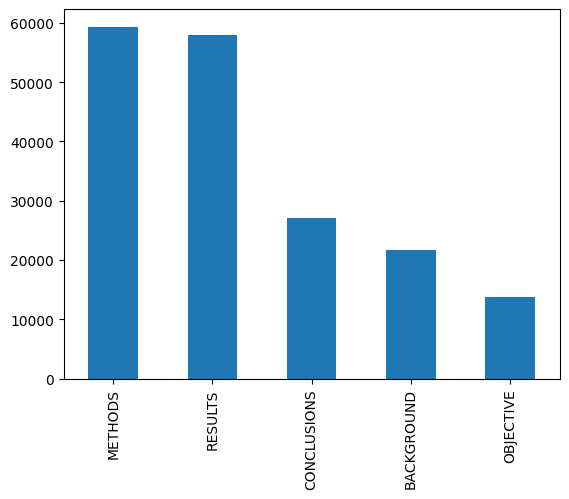

In [17]:
# Let's plot the distributions of labels in training data
train_df['target'].value_counts().plot(kind='bar');

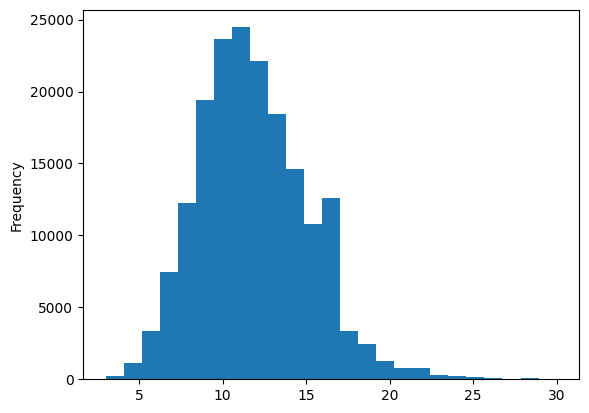

In [18]:
# Check out the length of the lines
train_df['total_lines'].plot(kind='hist', bins=25);

### Get the list of sentences

In [19]:
# Convert text lines into lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [20]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Making numeric labels (ML models require numeric labels)

### One hot encode labels

In [21]:
# One hot encode labels
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))

# Check what one hot encoding look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labes

In [22]:
# Extract labels ('target' columns) and encoed them into integers
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df['target'].to_numpy())

# Check what label encoding look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [23]:
# Get class names and number of classes from LabelEncoder
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## A series of modelling experiments

### Model 0: Getting a baseline (Naive Bayes with TF-IDF)

In [24]:
# Imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [25]:
# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

In [26]:
# Fit the model
model_0.fit(X=train_df['text'],
            y=train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [27]:
# Evaluate baseline model
baseline_score = model_0.score(X=val_df['text'],
                               y=val_labels_encoded)
print(f'Baseline model accuracy: %{baseline_score*100:.2f}')

Baseline model accuracy: %72.18


In [28]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [29]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    """
    Calculate the model accuracy, precision, recall, f1-score of a binary classification model.
    """
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred)
    # Calculate model precision, recall and f1-score using "weighted" average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    model_results = {
        'accuracy': model_accuracy,
        'precision': model_precision,
        'recall': model_recall,
        'f1': model_f1
    }
    return model_results

In [30]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 0.7218323844829869,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

### Text Vectorization and Embedding

Preparing our data for deep sequence model. Before we start building deeper models, we've got to create vectorization and embedding layers.

In [31]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

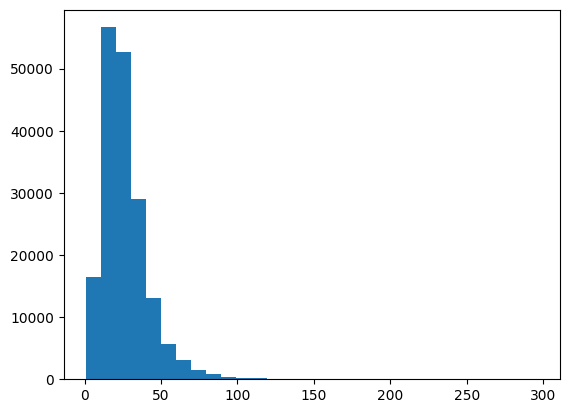

In [32]:
# What's the distribution look like?
plt.hist(sent_lens, bins=30);

In [33]:
# How long of a sentence length covers %95 of examples?
output_seq_len = np.percentile(sent_lens, 95)
output_seq_len

55.0

In [34]:
# Max sequence length in the training sentence
max(sent_lens)

296

In [35]:
# Create the text vectorization
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=68000, # how many unique vocabulary we have. This value got from the original paper
                                    output_sequence_length=int(output_seq_len))

In [36]:
# Fit the text vectorizer on the training data
text_vectorizer.adapt(train_sentences)

In [37]:
# Test out text vectorizer on random sentence
target_sentence = random.choice(train_sentences)
print(f'Random Sentence:\n', target_sentence, 2*'\n')
print(f'Text Vectorization:\n', text_vectorizer([target_sentence]))

Random Sentence:
 compared with to in the same group , wbc , n , crp , esr , il-@ , pt , tt , and d-d all increased in the control group at t@-t@ ( p < @ ) ; aptt increased at t@-t@ ( p < @ ) ; fib increased at t@-t@ ( p < @ ) . 


Text Vectorization:
 tf.Tensor(
[[   34     7     6     5     2   431    13  4981    40  1557  4204   460
   2687  2017     3  5295    62    96     5     2    35    13    15  2017
     14  8318    96    15  2017    14 12663    96    15  2017    14     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]], shape=(1, 55), dtype=int64)


In [38]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in vocab: {len(rct_20k_text_vocab)}')
print(f'Most common words in vocab: {rct_20k_text_vocab[:5]}')
print(f'Least common words in vocab: {rct_20k_text_vocab[-5:]}')

Number of words in vocab: 64841
Most common words in vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [39]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [40]:
# Creatin embedding layer
token_embed = tf.keras.layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                                      output_dim=128,
                                      mask_zero=True,
                                      name='token_embedding')

In [41]:
# Show example embedding
print(f'Sentence before vectorization:\n{target_sentence}\n')
vectorized_sentence = text_vectorizer([target_sentence])
print(f'Sentece after vectorization (before embedding):\n{vectorized_sentence}\n')
embedded_sentence = token_embed(vectorized_sentence)
print(f'Sentence after embedding:\n{embedded_sentence}\n')
print(f'Embedded shape: {embedded_sentence.shape}')

Sentence before vectorization:
compared with to in the same group , wbc , n , crp , esr , il-@ , pt , tt , and d-d all increased in the control group at t@-t@ ( p < @ ) ; aptt increased at t@-t@ ( p < @ ) ; fib increased at t@-t@ ( p < @ ) .

Sentece after vectorization (before embedding):
[[   34     7     6     5     2   431    13  4981    40  1557  4204   460
   2687  2017     3  5295    62    96     5     2    35    13    15  2017
     14  8318    96    15  2017    14 12663    96    15  2017    14     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[ 0.020259   -0.0198596   0.00974606 ... -0.00538184  0.03191398
   -0.00374962]
  [-0.00356015 -0.02916179 -0.024095   ...  0.01193199 -0.0189198
    0.00614438]
  [ 0.02232838  0.04841373  0.01755352 ...  0.03038212 -0.03181921
    0.01374507]
  ...
  [-0.03723728  0.01515635 -0.02460109 ... -0.03192114 -0.04958051
    0.00659575]
  [

### Creating datasets (making sure our data loads as fast as possible)

We are going to setup our data as fast as possible with TensorFlow tf.data API, many of these steps discuss in the icluded next two resources:

* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [42]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

# Check the train dataset
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [43]:
# Take the TensorSliceDataset's and turn them to prefected datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check the train dataset
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Model 1: Conv1D with token embedding

In [44]:
# Create 1D conv model to process sequence
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs) # text vectorization layer
x = token_embed(x) # embedding layer
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  activation='relu',
                  padding='same',
                  strides=1)(x) # Conv1D layer
x = layers.GlobalMaxPool1D()(x) # Global Pooling Layer
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs, name='Model_1_Conv1D')

# Compile the model
model_1.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [45]:
# Get the summary of model
model_1.summary()

Model: "Model_1_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5)              

In [46]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=5,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset))) # only validate on %10 of batches

Epoch 1/5
562/562 [==============================] - 43s 57ms/step - loss: 0.8315 - accuracy: 0.6818 - val_loss: 0.5838 - val_accuracy: 0.7859
Epoch 2/5
562/562 [==============================] - 8s 14ms/step - loss: 0.5758 - accuracy: 0.7896 - val_loss: 0.5374 - val_accuracy: 0.8032
Epoch 3/5
562/562 [==============================] - 5s 9ms/step - loss: 0.5420 - accuracy: 0.8023 - val_loss: 0.5233 - val_accuracy: 0.8108
Epoch 4/5
562/562 [==============================] - 4s 7ms/step - loss: 0.5225 - accuracy: 0.8077 - val_loss: 0.5247 - val_accuracy: 0.7959
Epoch 5/5
562/562 [==============================] - 6s 10ms/step - loss: 0.5299 - accuracy: 0.8077 - val_loss: 0.4990 - val_accuracy: 0.8145


In [47]:
# Evaluate model on the whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.4931 - accuracy: 0.8199


[0.49310600757598877, 0.8198729157447815]

In [48]:
# Make predictions (model predicts predcition probabilities of each classes)
model_1_preds_probs = model_1.predict(valid_dataset)
model_1_preds_probs, model_1_preds_probs.shape

945/945 [==============================] - 3s 3ms/step


(array([[6.5273470e-01, 2.4236152e-01, 4.4394545e-03, 7.9408675e-02,
         2.1055628e-02],
        [4.7187957e-01, 3.7786978e-01, 1.5397577e-02, 8.7784745e-02,
         4.7068268e-02],
        [3.5230881e-01, 1.3136351e-02, 1.0898199e-02, 6.2315208e-01,
         5.0456863e-04],
        ...,
        [5.6836387e-04, 1.1736098e-03, 1.1893106e-02, 5.6063815e-04,
         9.8580432e-01],
        [3.7432846e-02, 6.3197064e-01, 4.4459939e-02, 1.5023536e-02,
         2.7111298e-01],
        [5.2156538e-02, 9.3871766e-01, 5.5756741e-03, 1.3966750e-03,
         2.1535307e-03]], dtype=float32),
 (30212, 5))

In [49]:
# Convert preds probs to classes
model_1_preds = tf.argmax(model_1_preds_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [50]:
# Remind the class names
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [51]:
# Calculate model results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 0.8198728981861512,
 'precision': 0.821276335563568,
 'recall': 0.8198728981861512,
 'f1': 0.8171581227341933}

In [52]:
# Remind the baseline results
baseline_results

{'accuracy': 0.7218323844829869,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

Hmm.. It looks we got the better results with the Conv1D model..

### Model 2: Feature extraction with pretrained token embedding


In [53]:
# Import model from tensorflow hub
embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')

In [54]:
# Let's look at the a single sample
random_train_sentence = random.choice(train_sentences)
print(f'Random sentence:\n{random_train_sentence}\n')
embed_random_sentence = embed([random_train_sentence])
print(f'Sentence after embedding:\n{embed_random_sentence}\n')
print(f'Embed shape: {embed_random_sentence.shape}')

Random sentence:
an age-stratified randomisation scheme with block size of eight was computer-generated off-site at who .

Sentence after embedding:
[[-0.02458564  0.01538178 -0.05023319 -0.07743996 -0.03054411 -0.02625775
  -0.02222784 -0.00708562  0.06545324  0.0296578  -0.01180828  0.01639786
  -0.01370932  0.07181063 -0.05310286  0.0431774   0.056851   -0.06474934
  -0.01543516  0.0538184  -0.06558198  0.01025272 -0.01941259 -0.03791264
   0.0410253  -0.02396726  0.03692624  0.04490997 -0.00282766 -0.00600081
   0.04509862  0.04256104 -0.05069232  0.01996835 -0.05284223  0.06516568
   0.00736484  0.09506199  0.06701929 -0.03105635 -0.00189964  0.08090448
  -0.01125996 -0.01235563  0.04834697 -0.06826258 -0.0230772  -0.08646302
  -0.00969529 -0.05736986 -0.06694382 -0.0078351   0.06105184 -0.02914419
  -0.00342448 -0.06669825  0.00654416 -0.08499187  0.0603379  -0.07203679
   0.01468512 -0.02753376 -0.04897115 -0.00704349 -0.07333113  0.02123682
   0.03873011 -0.00335078  0.04095718

In [55]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name='USE')

In [56]:
# Create a model using sequential API
model_2 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model_2.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [57]:
# Get the model summary
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [58]:
# Fit the model
history_model_2 = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=5,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset))) # only validate on %10 of batches

Epoch 1/5
562/562 [==============================] - 11s 14ms/step - loss: 0.9185 - accuracy: 0.6492 - val_loss: 0.7957 - val_accuracy: 0.6915
Epoch 2/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7709 - accuracy: 0.7003 - val_loss: 0.7554 - val_accuracy: 0.7031
Epoch 3/5
562/562 [==============================] - 8s 13ms/step - loss: 0.7552 - accuracy: 0.7107 - val_loss: 0.7394 - val_accuracy: 0.7114
Epoch 4/5
562/562 [==============================] - 7s 13ms/step - loss: 0.7213 - accuracy: 0.7235 - val_loss: 0.7125 - val_accuracy: 0.7254
Epoch 5/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7281 - accuracy: 0.7211 - val_loss: 0.6912 - val_accuracy: 0.7317


In [59]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 10ms/step - loss: 0.6997 - accuracy: 0.7332


[0.699675977230072, 0.7331523895263672]

In [60]:
# Make some predictions with model 2
model_2_preds_probs = model_2.predict(val_sentences)
model_2_preds = tf.argmax(model_2_preds_probs, axis=1)
model_2_preds

945/945 [==============================] - 10s 9ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [61]:
# Calculate the results model 2
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 0.7331523897788959,
 'precision': 0.7292150902847495,
 'recall': 0.7331523897788959,
 'f1': 0.7273826252403979}

### Model 3: Conv1D with character embedding

In the previous models, we work with word level embedding but now, we will use the character embedding.

In [62]:
# Make function to split sentences into characters
def split_chars(text):
  return ' '.join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

'a n   a g e - s t r a t i f i e d   r a n d o m i s a t i o n   s c h e m e   w i t h   b l o c k   s i z e   o f   e i g h t   w a s   c o m p u t e r - g e n e r a t e d   o f f - s i t e   a t   w h o   .'

In [63]:
# Split sequnce-level data into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

# Check out the train chars
train_chars[:2]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .']

In [64]:
# What's the average character lengt
chars_lens = [len(sentence) for sentence in train_sentences]
mean_char_lens = np.mean(chars_lens)
mean_char_lens

149.3662574983337

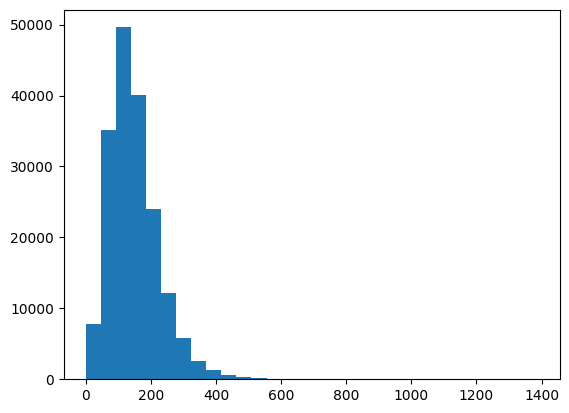

In [65]:
# Check the distribution of our sequences
plt.hist(chars_lens, bins=30);

In [66]:
# Fin the what character length cover %95 of sequence
output_seq_char_len = int(np.percentile(chars_lens, 95))
output_seq_char_len

290

In [67]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [68]:
# Create char level token vectorizer
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    # standardize=None, # set standardization=None  if you want to leave punctuation in
                                    name='char_vectorizer')

In [69]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [70]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different characters in tha character vocab: {len(char_vocab)}')
print(f'5 most common words: {char_vocab[:5]}')
print(f'5 least common words: {char_vocab[-5:]}')

Number of different characters in tha character vocab: 28
5 most common words: ['', '[UNK]', 'e', 't', 'i']
5 least common words: ['k', 'x', 'z', 'q', 'j']


In [71]:
# Test our character vectorization
random_train_chars = random.choice(train_chars)
print(f'Random chars before vectorization:\n{random_train_chars}\n')
print(f'After char vectorization:\n{char_vectorizer([random_train_chars])}\n')
print(f'Length of the vectorization:{len(char_vectorizer([random_train_chars])[0])}')

Random chars before vectorization:
a   s i g n i f i c a n t   p o s i t i v e   c o r r e l a t i o n   (   r   =   @   ,   p   <   @   )   b e t w e e n   k n o w l e d g e   s c o r e s   a n d   b e h a v i o r   s c o r e s   w a s   o b s e r v e d   .

After char vectorization:
[[ 5  9  4 18  6  4 17  4 11  5  6  3 14  7  9  4  3  4 21  2 11  7  8  8
   2 12  5  3  4  7  6  8 14 22  2  3 20  2  2  6 23  6  7 20 12  2 10 18
   2  9 11  7  8  2  9  5  6 10 22  2 13  5 21  4  7  8  9 11  7  8  2  9
  20  5  9  7 22  9  2  8 21  2 10  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

In [72]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab), # number of different charachters
                              output_dim=25, # got this values from original paper
                              mask_zero=True,
                              name='char_embedding')

In [73]:
# Test out charachter embedding
print(f'Charified text:\n{random_train_chars}\n')
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f'Embedded char:\n{char_embed_example}\n')
print(f'Embedded char shape:{char_embed_example.shape}')

Charified text:
a   s i g n i f i c a n t   p o s i t i v e   c o r r e l a t i o n   (   r   =   @   ,   p   <   @   )   b e t w e e n   k n o w l e d g e   s c o r e s   a n d   b e h a v i o r   s c o r e s   w a s   o b s e r v e d   .

Embedded char:
[[[ 0.03624261 -0.01055781  0.00943837 ...  0.03501329  0.02960912
    0.04301048]
  [-0.01882263  0.04849602 -0.02233435 ... -0.02568499 -0.01175529
    0.02897188]
  [-0.0361715   0.02259393 -0.02021216 ... -0.02381377 -0.00417192
   -0.01762808]
  ...
  [-0.0270293  -0.02509948  0.0422591  ... -0.0384859  -0.01886392
   -0.03260605]
  [-0.0270293  -0.02509948  0.0422591  ... -0.0384859  -0.01886392
   -0.03260605]
  [-0.0270293  -0.02509948  0.0422591  ... -0.0384859  -0.01886392
   -0.03260605]]]

Embedded char shape:(1, 290, 25)


In [74]:
# Build Conv1D model for character embeded data
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = char_vectorizer(inputs) # text vectorization layer
x = char_embed(x) # embedding layer
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  activation='relu',
                  padding='same',
                  strides=1)(x) # Conv1D layer
x = layers.GlobalMaxPool1D()(x) # Global Pooling Layer
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_3 = tf.keras.Model(inputs, outputs, name='Model_3_Conv1D')

# Compile the model
model_3.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [75]:
# Get the model summary
model_3.summary()

Model: "Model_3_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embedding (Embedding)  (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 5)              

In [76]:
# Turn char data into TnesorFlow Datasets
train_dataset_char = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot))
val_dataset_char = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot))
test_dataset_char = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot))

# Take the TensorSliceDataset's and turn them into prefected datasets
train_dataset_char = train_dataset_char.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset_char = val_dataset_char.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset_char = test_dataset_char.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset_char

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [77]:
# Fit the model
model_3_history = model_3.fit(train_dataset_char,
                              steps_per_epoch=int(0.1*len(val_dataset_char)),
                              epochs=5,
                              validation_data=val_dataset_char,
                              validation_steps=int(0.1*len(val_dataset_char)))

Epoch 1/5
94/94 [==============================] - 2s 14ms/step - loss: 1.4891 - accuracy: 0.3617 - val_loss: 1.4403 - val_accuracy: 0.4325
Epoch 2/5
94/94 [==============================] - 1s 8ms/step - loss: 1.4147 - accuracy: 0.4475 - val_loss: 1.3638 - val_accuracy: 0.4269
Epoch 3/5
94/94 [==============================] - 1s 8ms/step - loss: 1.3157 - accuracy: 0.4528 - val_loss: 1.2449 - val_accuracy: 0.4910
Epoch 4/5
94/94 [==============================] - 1s 8ms/step - loss: 1.2187 - accuracy: 0.5110 - val_loss: 1.1477 - val_accuracy: 0.5439
Epoch 5/5
94/94 [==============================] - 1s 8ms/step - loss: 1.1043 - accuracy: 0.5628 - val_loss: 1.0837 - val_accuracy: 0.5658


In [78]:
# Evaluate the model on whole validation data
model_3.evaluate(val_dataset_char)

945/945 [==============================] - 4s 4ms/step - loss: 1.0881 - accuracy: 0.5663


[1.0881471633911133, 0.5662650465965271]

In [79]:
# Make some predictions
model_3_preds_probs = model_3.predict(val_chars)
model_3_preds = tf.argmax(model_3_preds_probs, axis=1)
model_3_preds

945/945 [==============================] - 3s 3ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 2, ..., 4, 4, 0])>

In [80]:
# Calculate the results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 0.5662650602409639,
 'precision': 0.5613553569047796,
 'recall': 0.5662650602409639,
 'f1': 0.5291198439291218}

### Model 4: Combining pretrained token embeddings + character embenddings (hybrid)

1. Create a token-level embedding model (similiar model_1)
2. Create a character-level model (similiar model_3)
3. Combine 1 and 2 with a concatenate (layers.Concatenate)
4. Build a series of output layers
5. Construct a model which takes token and character-level sequence as input and produces sequence label probabilities as output

In [100]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embeddings = sentence_encoder_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (hybrid embedding)
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output, char_model.output])

# 4. Create output layers - adding in Dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

# 5.Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name='model_5_token_and_char_embedding')

In [101]:
# Get the summary of model 4
model_4.summary()

Model: "model_5_token_and_char_embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   ['

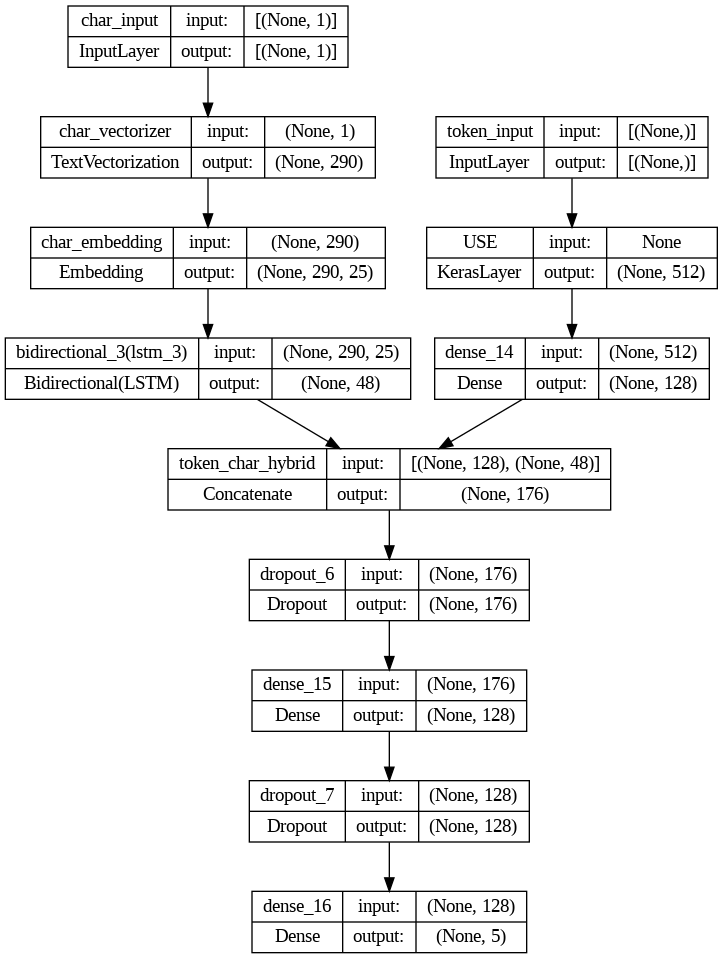

In [102]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [103]:
# Compile token char model
model_4.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [104]:
# Combine token and character data into tf.data Dataset
train_token_char_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_token_char_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_token_char_dataset = tf.data.Dataset.zip((train_token_char_data, train_token_char_labels)) # combine data and labels

# Prefetch and batch train data
train_token_char_dataset = train_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_token_char_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [105]:
# Repat the above steps for our validation data
val_token_char_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_token_char_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_token_char_dataset = tf.data.Dataset.zip((val_token_char_data, val_token_char_labels)) # combine data and labels

# Prefetch and batch validation data
val_token_char_dataset = val_token_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_token_char_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [106]:
# Fit the model 4
model_4_history = model_4.fit(train_token_char_dataset,
                              steps_per_epoch=int(0.1*len(train_token_char_dataset)),
                              epochs=5,
                              validation_data=val_token_char_dataset,
                              validation_steps=int(0.1*len(val_token_char_dataset)))

Epoch 1/5
562/562 [==============================] - 39s 51ms/step - loss: 0.9705 - accuracy: 0.6118 - val_loss: 0.7655 - val_accuracy: 0.7035
Epoch 2/5
562/562 [==============================] - 25s 45ms/step - loss: 0.7939 - accuracy: 0.6897 - val_loss: 0.7106 - val_accuracy: 0.7304
Epoch 3/5
562/562 [==============================] - 23s 41ms/step - loss: 0.7680 - accuracy: 0.7089 - val_loss: 0.6859 - val_accuracy: 0.7417
Epoch 4/5
562/562 [==============================] - 26s 47ms/step - loss: 0.7366 - accuracy: 0.7221 - val_loss: 0.6650 - val_accuracy: 0.7573
Epoch 5/5
562/562 [==============================] - 25s 44ms/step - loss: 0.7468 - accuracy: 0.7160 - val_loss: 0.6551 - val_accuracy: 0.7470


In [107]:
# Evaluate model on the whole validation data
model_4.evaluate(val_token_char_dataset)

945/945 [==============================] - 18s 19ms/step - loss: 0.6626 - accuracy: 0.7456


[0.662582516670227, 0.7456308603286743]

In [111]:
# Make some prediction
model_4_preds_probs = model_4.predict(val_token_char_dataset)
model_4_preds_probs

945/945 [==============================] - 17s 18ms/step


array([[4.82008904e-01, 2.92412996e-01, 8.17998685e-03, 2.04710662e-01,
        1.26874875e-02],
       [3.63635242e-01, 4.97206658e-01, 6.17121160e-03, 1.26755416e-01,
        6.23146072e-03],
       [3.18921715e-01, 8.86091664e-02, 1.37929037e-01, 4.12202060e-01,
        4.23380844e-02],
       ...,
       [6.91966154e-04, 3.77399917e-03, 5.85372336e-02, 1.97586385e-04,
        9.36799228e-01],
       [7.10435351e-03, 2.78310515e-02, 4.42740053e-01, 3.67917703e-03,
        5.18645346e-01],
       [1.82400942e-01, 5.36143661e-01, 2.18850955e-01, 1.14171384e-02,
        5.11873700e-02]], dtype=float32)

In [112]:
# Convert prediction probabilities into classes
model_4_preds = tf.argmax(model_4_preds_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [115]:
# Calculate the results
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 0.7456308751489474,
 'precision': 0.7423146234243302,
 'recall': 0.7456308751489474,
 'f1': 0.739784894222652}